In [ ]:
# install SQL

!pip install sqlalchemy

!pip install pandasql

In [ ]:
# install kaggle

%%capture

!apt update

!pip install kaggle

In [6]:
# Run this cell to mount your drive (you will be prompted to sign in)

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Create the kaggle directory and don’t run this cell more than once unless restarting kernel)

!mkdir ~/.kaggle

# Read the uploaded kaggle.json file

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

# Download dataset

!!kaggle datasets download -d agungpambudi/network-malware-detection-connection-analysis

# Unzip folder in Colab content folder

!unzip /content/network-malware-detection-connection-analysis.zip

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
unzip:  cannot find or open /content/network-malware-detection-connection-analysis.zip, /content/network-malware-detection-connection-analysis.zip.zip or /content/network-malware-detection-connection-analysis.zip.ZIP.


In [8]:
import pandas as pd
import pandasql as ps

# Load the dataset
file_path = '/content/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv'
df = pd.read_csv(file_path, delimiter='|')

# Display the first few rows of the dataset
df.head()

ts                 uid        id.orig_h  id.orig_p  \
0  1.525880e+09  CUmrqr4svHuSXJy5z7  192.168.100.103      51524   
1  1.525880e+09  CH98aB3s1kJeq6SFOc  192.168.100.103      56305   
2  1.525880e+09   C3GBTkINvXNjVGtN5  192.168.100.103      41101   
3  1.525880e+09   CDe43c1PtgynajGI6  192.168.100.103      60905   
4  1.525880e+09  CJaDcG3MZzvf1YVYI4  192.168.100.103      44301   

         id.resp_h  id.resp_p proto service  duration orig_bytes  ...  \
0   65.127.233.163         23   tcp       -  2.999051          0  ...   
1    63.150.16.171         23   tcp       -         -          -  ...   
2     111.40.23.49         23   tcp       -         -          -  ...   
3  131.174.215.147         23   tcp       -  2.998796          0  ...   
4      91.42.47.63         23   tcp       -         -          -  ...   

  local_resp missed_bytes history orig_pkts  orig_ip_bytes resp_pkts  \
0          -            0       S         3            180         0   
1          -            0       S         1             60         0   
2          -            0       S         1             60         0   
3          -            0       S         3            180         0   
4          -            0       S         1             60         0   

   resp_ip_bytes  tunnel_parents      label             detailed-label  
0              0               -  Malicious  PartOfAHorizontalPortScan  
1              0               -  Malicious  PartOfAHorizontalPortScan  
2              0               -  Malicious  PartOfAHorizontalPortScan  
3              0               -  Malicious  PartOfAHorizontalPortScan  
4              0               -  Malicious  PartOfAHorizontalPortScan  

[5 rows x 23 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198581 entries, 0 to 198580
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ts              198581 non-null  float64
 1   uid             198581 non-null  object 
 2   id.orig_h       198581 non-null  object 
 3   id.orig_p       198581 non-null  int64  
 4   id.resp_h       198581 non-null  object 
 5   id.resp_p       198581 non-null  int64  
 6   proto           198581 non-null  object 
 7   service         198581 non-null  object 
 8   duration        198581 non-null  object 
 9   orig_bytes      198581 non-null  object 
 10  resp_bytes      198581 non-null  object 
 11  conn_state      198581 non-null  object 
 12  local_orig      198581 non-null  object 
 13  local_resp      198581 non-null  object 
 14  missed_bytes    198581 non-null  int64  
 15  history         198581 non-null  object 
 16  orig_pkts       198581 non-null  int64  
 17  orig_ip_by

In [10]:
df['label'].value_counts()

Malicious    108176
Benign        90405
Name: label, dtype: int64

In [11]:
# Rename the specified columns
df = df.rename(columns={
    'id.orig_h': 'Source_IP',
    'id.orig_p': 'Source_Port',
    'id.resp_h': 'Destination_IP',
    'id.resp_p': 'Destination_Port',
    'detailed-label': 'detailed_label'
})

# Change columns to string where applicable
df[['Source_IP', 'Destination_IP', 'proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'history', 'tunnel_parents', 'label', 'detailed_label']] = df[['Source_IP', 'Destination_IP', 'proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'history', 'tunnel_parents', 'label', 'detailed_label']].astype(str)

In [12]:
# Replace dashes with NaN and convert columns to numeric data types
df['orig_bytes'] = pd.to_numeric(df['orig_bytes'], errors='coerce')
df['resp_bytes'] = pd.to_numeric(df['resp_bytes'], errors='coerce')
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

# Check the changes to ensure the conversion was successful
df[['orig_bytes', 'resp_bytes', 'duration']].head()

orig_bytes  resp_bytes  duration
0         0.0         0.0  2.999051
1         NaN         NaN       NaN
2         NaN         NaN       NaN
3         0.0         0.0  2.998796
4         NaN         NaN       NaN

In [16]:
# Task 1: Top 20 IP address pairs with highest number of benign connections with non-zero bytes
query = """
SELECT Source_IP, Destination_IP, COUNT(*) AS num_connections
FROM df
WHERE label = 'Benign' AND (orig_bytes > 0 OR resp_bytes > 0)
GROUP BY Source_IP, Destination_IP
ORDER BY num_connections DESC
LIMIT 20
"""

# Execute the query using pandasql
top_20_benign_ip_pairs = ps.sqldf(query, locals())

print(top_20_benign_ip_pairs)

          Source_IP   Destination_IP  num_connections
0   192.168.100.103    147.231.100.5             1143
1   192.168.100.103   89.221.214.130              349
2   192.168.100.103    37.187.104.44              306
3   192.168.100.103   213.239.154.12              266
4     192.168.100.1  192.168.100.103              184
5     64.132.73.170  192.168.100.103                2
6      77.90.11.101  192.168.100.103                2
7       100.64.8.34  192.168.100.103                1
8     100.72.251.10  192.168.100.103                1
9     100.91.125.22  192.168.100.103                1
10    101.100.3.241  192.168.100.103                1
11    103.100.93.22  192.168.100.103                1
12    106.185.21.98  192.168.100.103                1
13    107.138.65.11  192.168.100.103                1
14   108.167.133.94  192.168.100.103                1
15  109.104.221.224  192.168.100.103                1
16    109.130.192.1  192.168.100.103                1
17  109.235.228.210  192.168

In [17]:
#TASK 2
query_malicious = '''
SELECT Source_IP, Destination_IP, COUNT(*) as total_connections
FROM df
WHERE label = 'Malicious' AND ((orig_bytes > 0) OR (resp_bytes > 0))
GROUP BY Source_IP, Destination_IP
ORDER BY total_connections DESC
LIMIT 20
'''

top_20_ip_pairs_malicious = ps.sqldf(query_malicious)

print(top_20_ip_pairs_malicious)

          Source_IP   Destination_IP  total_connections
0   192.168.100.103  104.224.253.146                121
1   192.168.100.103   137.221.16.255                121
2   192.168.100.103     171.91.73.45                121
3   192.168.100.103   175.182.77.163                121
4   192.168.100.103     181.30.51.33                121
5   192.168.100.103   181.55.148.118                121
6   192.168.100.103    188.9.179.150                121
7   192.168.100.103   198.178.126.44                121
8   192.168.100.103   221.235.207.85                121
9   192.168.100.103     31.154.30.22                121
10  192.168.100.103    31.41.234.123                121
11  192.168.100.103    61.101.126.35                121
12  192.168.100.103    67.208.21.230                121
13  192.168.100.103      71.181.6.40                121
14  192.168.100.103   83.166.183.225                121
15  192.168.100.103   86.126.120.223                121
16  192.168.100.103   191.250.200.68            

If we observe, 192.168.100.103 is the most common source ip address in both benign and malicious connection. So, we can't conclude that if a source ip address is 192.168.100.103 then it's benign or malicious. So, using source and destination ip address data is not providing any unique information for analysis. Therefore, we can remove those columns.

Justification for removing Source_Port and Destination_Port columns: If port numbers themselves are not providing meaningful insights or if they're not relevant to the analysis beyond what's captured by other features, it may be justified to remove these columns.

In [18]:
# TASK4
df = df.drop(columns=['Source_IP', 'Destination_IP'])
df.head()

ts                 uid  Source_Port  Destination_Port proto  \
0  1.525880e+09  CUmrqr4svHuSXJy5z7        51524                23   tcp   
1  1.525880e+09  CH98aB3s1kJeq6SFOc        56305                23   tcp   
2  1.525880e+09   C3GBTkINvXNjVGtN5        41101                23   tcp   
3  1.525880e+09   CDe43c1PtgynajGI6        60905                23   tcp   
4  1.525880e+09  CJaDcG3MZzvf1YVYI4        44301                23   tcp   

  service  duration  orig_bytes  resp_bytes conn_state  ... local_resp  \
0       -  2.999051         0.0         0.0         S0  ...          -   
1       -       NaN         NaN         NaN         S0  ...          -   
2       -       NaN         NaN         NaN         S0  ...          -   
3       -  2.998796         0.0         0.0         S0  ...          -   
4       -       NaN         NaN         NaN         S0  ...          -   

  missed_bytes  history orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  \
0            0        S         3            180          0              0   
1            0        S         1             60          0              0   
2            0        S         1             60          0              0   
3            0        S         3            180          0              0   
4            0        S         1             60          0              0   

   tunnel_parents      label             detailed_label  
0               -  Malicious  PartOfAHorizontalPortScan  
1               -  Malicious  PartOfAHorizontalPortScan  
2               -  Malicious  PartOfAHorizontalPortScan  
3               -  Malicious  PartOfAHorizontalPortScan  
4               -  Malicious  PartOfAHorizontalPortScan  

[5 rows x 21 columns]

In [24]:
# TASK 4
query_bengin_non_zero = '''
SELECT Source_Port, Destination_Port, COUNT(*) AS num_connections
FROM df
WHERE label = 'Benign' AND (orig_bytes > 0 OR resp_bytes > 0)
GROUP BY Source_Port, Destination_Port
ORDER BY num_connections DESC
'''

bengin_non_zero = ps.sqldf(query_bengin_non_zero)

print(bengin_non_zero)

   Source_Port  Destination_Port  num_connections
0          123               123             2064
1            3                 1              376
2           11                 0                8
3            3                13                3
4            3                 3                2


In [23]:
# TASK 5
top_20_ports_malicious = '''
SELECT Source_Port, Destination_Port, COUNT(*) AS num_attacks
FROM df
WHERE label = 'Malicious' AND (orig_bytes > 0 OR resp_bytes > 0)
GROUP BY Source_Port, Destination_Port
ORDER BY num_attacks DESC
LIMIT 20
'''

ports_malicious = ps.sqldf(top_20_ports_malicious)

print(ports_malicious)

    Source_Port  Destination_Port  num_attacks
0         46161                23            2
1         46186                23            2
2         46248                23            2
3         46261                23            2
4         46289                23            2
5         46387                23            2
6         46400                23            2
7         46480                23            2
8         47847                23            2
9         47886                23            2
10        47902                23            2
11        47909                23            2
12        47918                23            2
13        47939                23            2
14        47951                23            2
15        47961                23            2
16        47970                23            2
17        47987                23            2
18        47993                23            2
19        48002                23            2


The high variance in source ports and the dual-use nature of destination ports suggest that these features might have low predictive value on their own. Model relying on these might be prone to high false positive or negative rates.

# TASK 6
Justification for removing Source_Port and Destination_Port columns: Similar to justification for removing Source_IP and Destination_IP columns,we can analyze whether these columns provide significant information that is not already captured by other columns. If port numbers are not relevant to the analysis or are sufficiently represented by other features, then removing these columns may be justified.

In [25]:
df = df.drop(columns=['Source_Port', 'Destination_Port'])

In [28]:
# TASK 7
# Replace '-' with 0 for the specified columns
df['local_orig'] = df['local_orig'].replace('-', 0)
df['local_resp'] = df['local_resp'].replace('-', 0)
df['missed_bytes'] = df['missed_bytes'].replace('-', 0)  # Note: This column might already be numeric.
df['tunnel_parents'] = df['tunnel_parents'].replace('-', 0)

In [29]:
# TASK 8
query_total = '''
SELECT label,
       SUM(CAST(local_orig AS INTEGER)) AS total_local_orig,
       SUM(CAST(local_resp AS INTEGER)) AS total_local_resp,
       SUM(missed_bytes) AS total_missed_bytes,
       SUM(CAST(tunnel_parents AS INTEGER)) AS total_tunnel_parents
FROM df
GROUP BY label'''

total = ps.sqldf(query_total)
print(total)

       label  total_local_orig  total_local_resp  total_missed_bytes  \
0     Benign                 0                 0                   0   
1  Malicious                 0                 0                   0   

   total_tunnel_parents  
0                     0  
1                     0  


# TASK 9
Justification for removing local_orig, local_resp, missed_bytes, tunnel_parents columns: We can justify removing these columns if they do not provide significant information or if their information can be captured by other features in the dataset.For example, if these columns are mainly filled with 0s or if their information is already represented by other features, then removing them may reduce dimensionality without significant loss of information

# TASK 10
Columns ts (timestamp) and uid (unique identifier) should be removed because: Timestamp and unique identifier columns are typically not relevant for predictive modeling tasks as they do not contain meaningful information for classification or regression.Timestamps can be converted into more meaningful features (e.g., hour of the day, day of the week) if needed, but directly using them as features might not be useful.Unique identifiers are generally not useful for modeling as they don't contain any inherent predictive power and might even confuse the model if used improperly.

In [30]:
# TASK 11
# Remove the specified columns from the DataFrame
df = df.drop(columns=['local_orig', 'local_resp', 'missed_bytes', 'tunnel_parents'])

# Display the first few rows to confirm the removal
df.head()

ts                 uid proto service  duration  orig_bytes  \
0  1.525880e+09  CUmrqr4svHuSXJy5z7   tcp       -  2.999051         0.0   
1  1.525880e+09  CH98aB3s1kJeq6SFOc   tcp       -       NaN         NaN   
2  1.525880e+09   C3GBTkINvXNjVGtN5   tcp       -       NaN         NaN   
3  1.525880e+09   CDe43c1PtgynajGI6   tcp       -  2.998796         0.0   
4  1.525880e+09  CJaDcG3MZzvf1YVYI4   tcp       -       NaN         NaN   

   resp_bytes conn_state history  orig_pkts  orig_ip_bytes  resp_pkts  \
0         0.0         S0       S          3            180          0   
1         NaN         S0       S          1             60          0   
2         NaN         S0       S          1             60          0   
3         0.0         S0       S          3            180          0   
4         NaN         S0       S          1             60          0   

   resp_ip_bytes      label             detailed_label  
0              0  Malicious  PartOfAHorizontalPortScan  
1              0  Malicious  PartOfAHorizontalPortScan  
2              0  Malicious  PartOfAHorizontalPortScan  
3              0  Malicious  PartOfAHorizontalPortScan  
4              0  Malicious  PartOfAHorizontalPortScan

Columns with unique values for each record, such as IDs or timestamps, typically do not have any predictive power for the task at hand. These features do not help the model learn any pattern since each value is distinct and doesnt repeat across the dataset. So, we can drop ts and uid

In [31]:
df = df.drop(columns=['ts','uid','detailed_label'])
df.head()

proto service  duration  orig_bytes  resp_bytes conn_state history  \
0   tcp       -  2.999051         0.0         0.0         S0       S   
1   tcp       -       NaN         NaN         NaN         S0       S   
2   tcp       -       NaN         NaN         NaN         S0       S   
3   tcp       -  2.998796         0.0         0.0         S0       S   
4   tcp       -       NaN         NaN         NaN         S0       S   

   orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes      label  
0          3            180          0              0  Malicious  
1          1             60          0              0  Malicious  
2          1             60          0              0  Malicious  
3          3            180          0              0  Malicious  
4          1             60          0              0  Malicious

In [34]:
# TASK 12
df['service'] = pd.to_numeric(df['service'], errors='coerce').fillna(0).astype(int)
df[['duration', 'orig_bytes', 'resp_bytes']] = df[['duration', 'orig_bytes', 'resp_bytes']].fillna(0)

In [36]:
# TASK 13
query_conn_state_counts = '''
SELECT
    conn_state,
    SUM(CASE WHEN label = 'Malicious' THEN 1 ELSE 0 END) AS Num_attacks,
    SUM(CASE WHEN label = 'Benign' THEN 1 ELSE 0 END) AS Num_benign
FROM df
GROUP BY conn_state
'''
conn_state_counts = ps.sqldf(query_conn_state_counts)
print(conn_state_counts)

  conn_state  Num_attacks  Num_benign
0        OTH            0        5026
1        REJ         1245         134
2       RSTO           20           0
3     RSTOS0            1          35
4       RSTR          387           1
5      RSTRH            8           0
6         S0       104605       83144
7         S1            5           1
8         S2           14           0
9         SF         1891        2064


In [37]:
#TASK 14
query_history_counts = '''
SELECT
    history,
    SUM(CASE WHEN label = 'Malicious' THEN 1 ELSE 0 END) AS Num_attacks,
    SUM(CASE WHEN label = 'Benign' THEN 1 ELSE 0 END) AS Num_benign
FROM df
GROUP BY history
'''

history_counts = ps.sqldf(query_history_counts)
print(history_counts)

       history  Num_attacks  Num_benign
0            -            0        5026
1            D            8       74434
2           D^            0           5
3           Dd            0        2064
4            R            0          35
5            S       104597        8705
6          SaR            1           0
7          ShA            5           1
8        ShADF            2           0
9   ShADFadfRR            1           0
10      ShADFr            3           0
11      ShADaF            1           0
12     ShADadR            3           0
13    ShADadRf            4           0
14    ShADadfF          317           0
15    ShADadfR           12           0
16     ShADafF          121           0
17     ShADafr          120           0
18    ShADarfF            1           0
19    ShADdafR            1           0
20    ShADdfFa          121           0
21       ShADr            6           0
22     ShADrfR            1           0
23        ShAF            5           0


In [38]:
# TASK 15
df['history'] = df['history'].apply(lambda x: x if x in ['S', 'Sr'] else 'Others')

In [40]:
# TASK 16
query_proto_counts = '''
SELECT
    proto,
    SUM(CASE WHEN label = 'Malicious' THEN 1 ELSE 0 END) AS Num_attacks,
    SUM(CASE WHEN label = 'Benign' THEN 1 ELSE 0 END) AS Num_benign
FROM df
GROUP BY proto
'''

proto_counts = ps.sqldf(query_proto_counts)
print(proto_counts)

  proto  Num_attacks  Num_benign
0  icmp            0        5026
1   tcp       108168        8876
2   udp            8       76503


In [52]:
# TASK 17
query_proto_probabilities = '''
SELECT
    proto,
    Num_attacks,
    Num_benign,
    (Num_attacks * 1.0) / (Num_attacks + Num_benign) AS Prob_attack,
    (Num_benign * 1.0) / (Num_attacks + Num_benign) AS Prob_benign
FROM (
    SELECT
        proto,
        SUM(CASE WHEN label = 'Malicious' THEN 1 ELSE 0 END) AS Num_attacks,
        SUM(CASE WHEN label = 'Benign' THEN 1 ELSE 0 END) AS Num_benign
    FROM df
    WHERE proto IN ('tcp', 'udp')
    GROUP BY proto
) AS subquery
'''

proto_probabilities = ps.sqldf(query_proto_probabilities)
print(proto_probabilities)

  proto  Num_attacks  Num_benign  Prob_attack  Prob_benign
0   tcp       108168        8876     0.924165     0.075835
1   udp            8       76503     0.000105     0.999895


In [54]:
# TASK 18
query_entropy = '''
SELECT *, -Prob_attack*LOG2(Prob_attack)-Prob_benign*LOG2(Prob_benign) AS entropy
FROM proto_probabilities
GROUP BY proto
'''
entropy = ps.sqldf(query_entropy)
print(entropy)

  proto  Num_attacks  Num_benign  Prob_attack  Prob_benign   entropy
0   tcp       108168        8876     0.924165     0.075835  0.387330
1   udp            8       76503     0.000105     0.999895  0.001533


In [55]:
# TASK 19
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert the three string labels 'conn_state', 'history', 'proto' to integers
df['conn_state'] = label_encoder.fit_transform(df['conn_state'])
df['history'] = label_encoder.fit_transform(df['history'])
df['proto'] = label_encoder.fit_transform(df['proto'])

In [56]:
# Manually map 'Benign' to 0 and 'Malicious' to 1 for the 'label' column
df['label'] = df['label'].map({'Benign': 0, 'Malicious': 1})

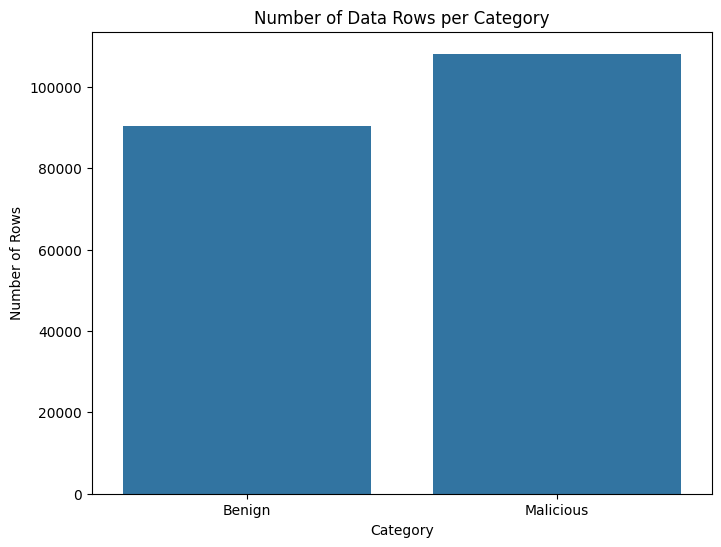

In [59]:
# TASK 21
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of data rows for each category in the 'label' column
label_counts = df['label'].value_counts()

# Plot the counts using a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Number of Data Rows per Category')
plt.xlabel('Category')
plt.ylabel('Number of Rows')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malicious'])  # Replacing 0 and 1 with text labels for clarity
plt.show()

In [58]:
# Find the number of instances in the smaller category
min_count = df['label'].value_counts().min()
print(min_count)

90405


In [69]:
# Separate the data into Benign and Malicious categories
benign_data = df[df['label'] == 0]
malicious_data = df[df['label'] == 1]

# Downsample the larger category to have the same number of samples as the smaller category
min_samples = min(len(benign_data), len(malicious_data))
downsampled_benign_data = benign_data.sample(n=min_samples, random_state=42)
downsampled_malicious_data = malicious_data.sample(n=min_samples, random_state=42)

# Concatenate the downsampled dataframes
downsampled_df = pd.concat([downsampled_benign_data, downsampled_malicious_data])

# Shuffle the concatenated dataframe
downsampled_df = downsampled_df.sample(frac=1, random_state=42)

# Check the distribution of labels
print(downsampled_df['label'].value_counts())

0    90405
1    90405
Name: label, dtype: int64


In [71]:
features = downsampled_df.iloc[:, :11]

# The target is the 'label' column
target = downsampled_df[['label']]

# Display the first few rows of each to verify
features.head(), target.head()

# Save the dataframes to files
features.to_csv('features.csv', index=False)
target.to_csv('target.csv', index=False)

# Display the first few rows of each to verify
features.head(), target.head()

(        proto  service  duration  orig_bytes  resp_bytes  conn_state  history  \
 6323        2        0       0.0         0.0         0.0           6        0   
 127141      2        0       0.0         0.0         0.0           6        0   
 151549      1        0       0.0         0.0         0.0           6        1   
 97032       1        0       0.0         0.0         0.0           6        1   
 131220      1        0       0.0         0.0         0.0           6        1   
 
         orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  
 6323            1             40          0              0  
 127141          1             40          0              0  
 151549          1             60          0              0  
 97032           1             60          0              0  
 131220          1             60          0              0  ,
         label
 6323        0
 127141      0
 151549      1
 97032       1
 131220      1)

Split the data into training and testing sets:

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3,random_state=42)

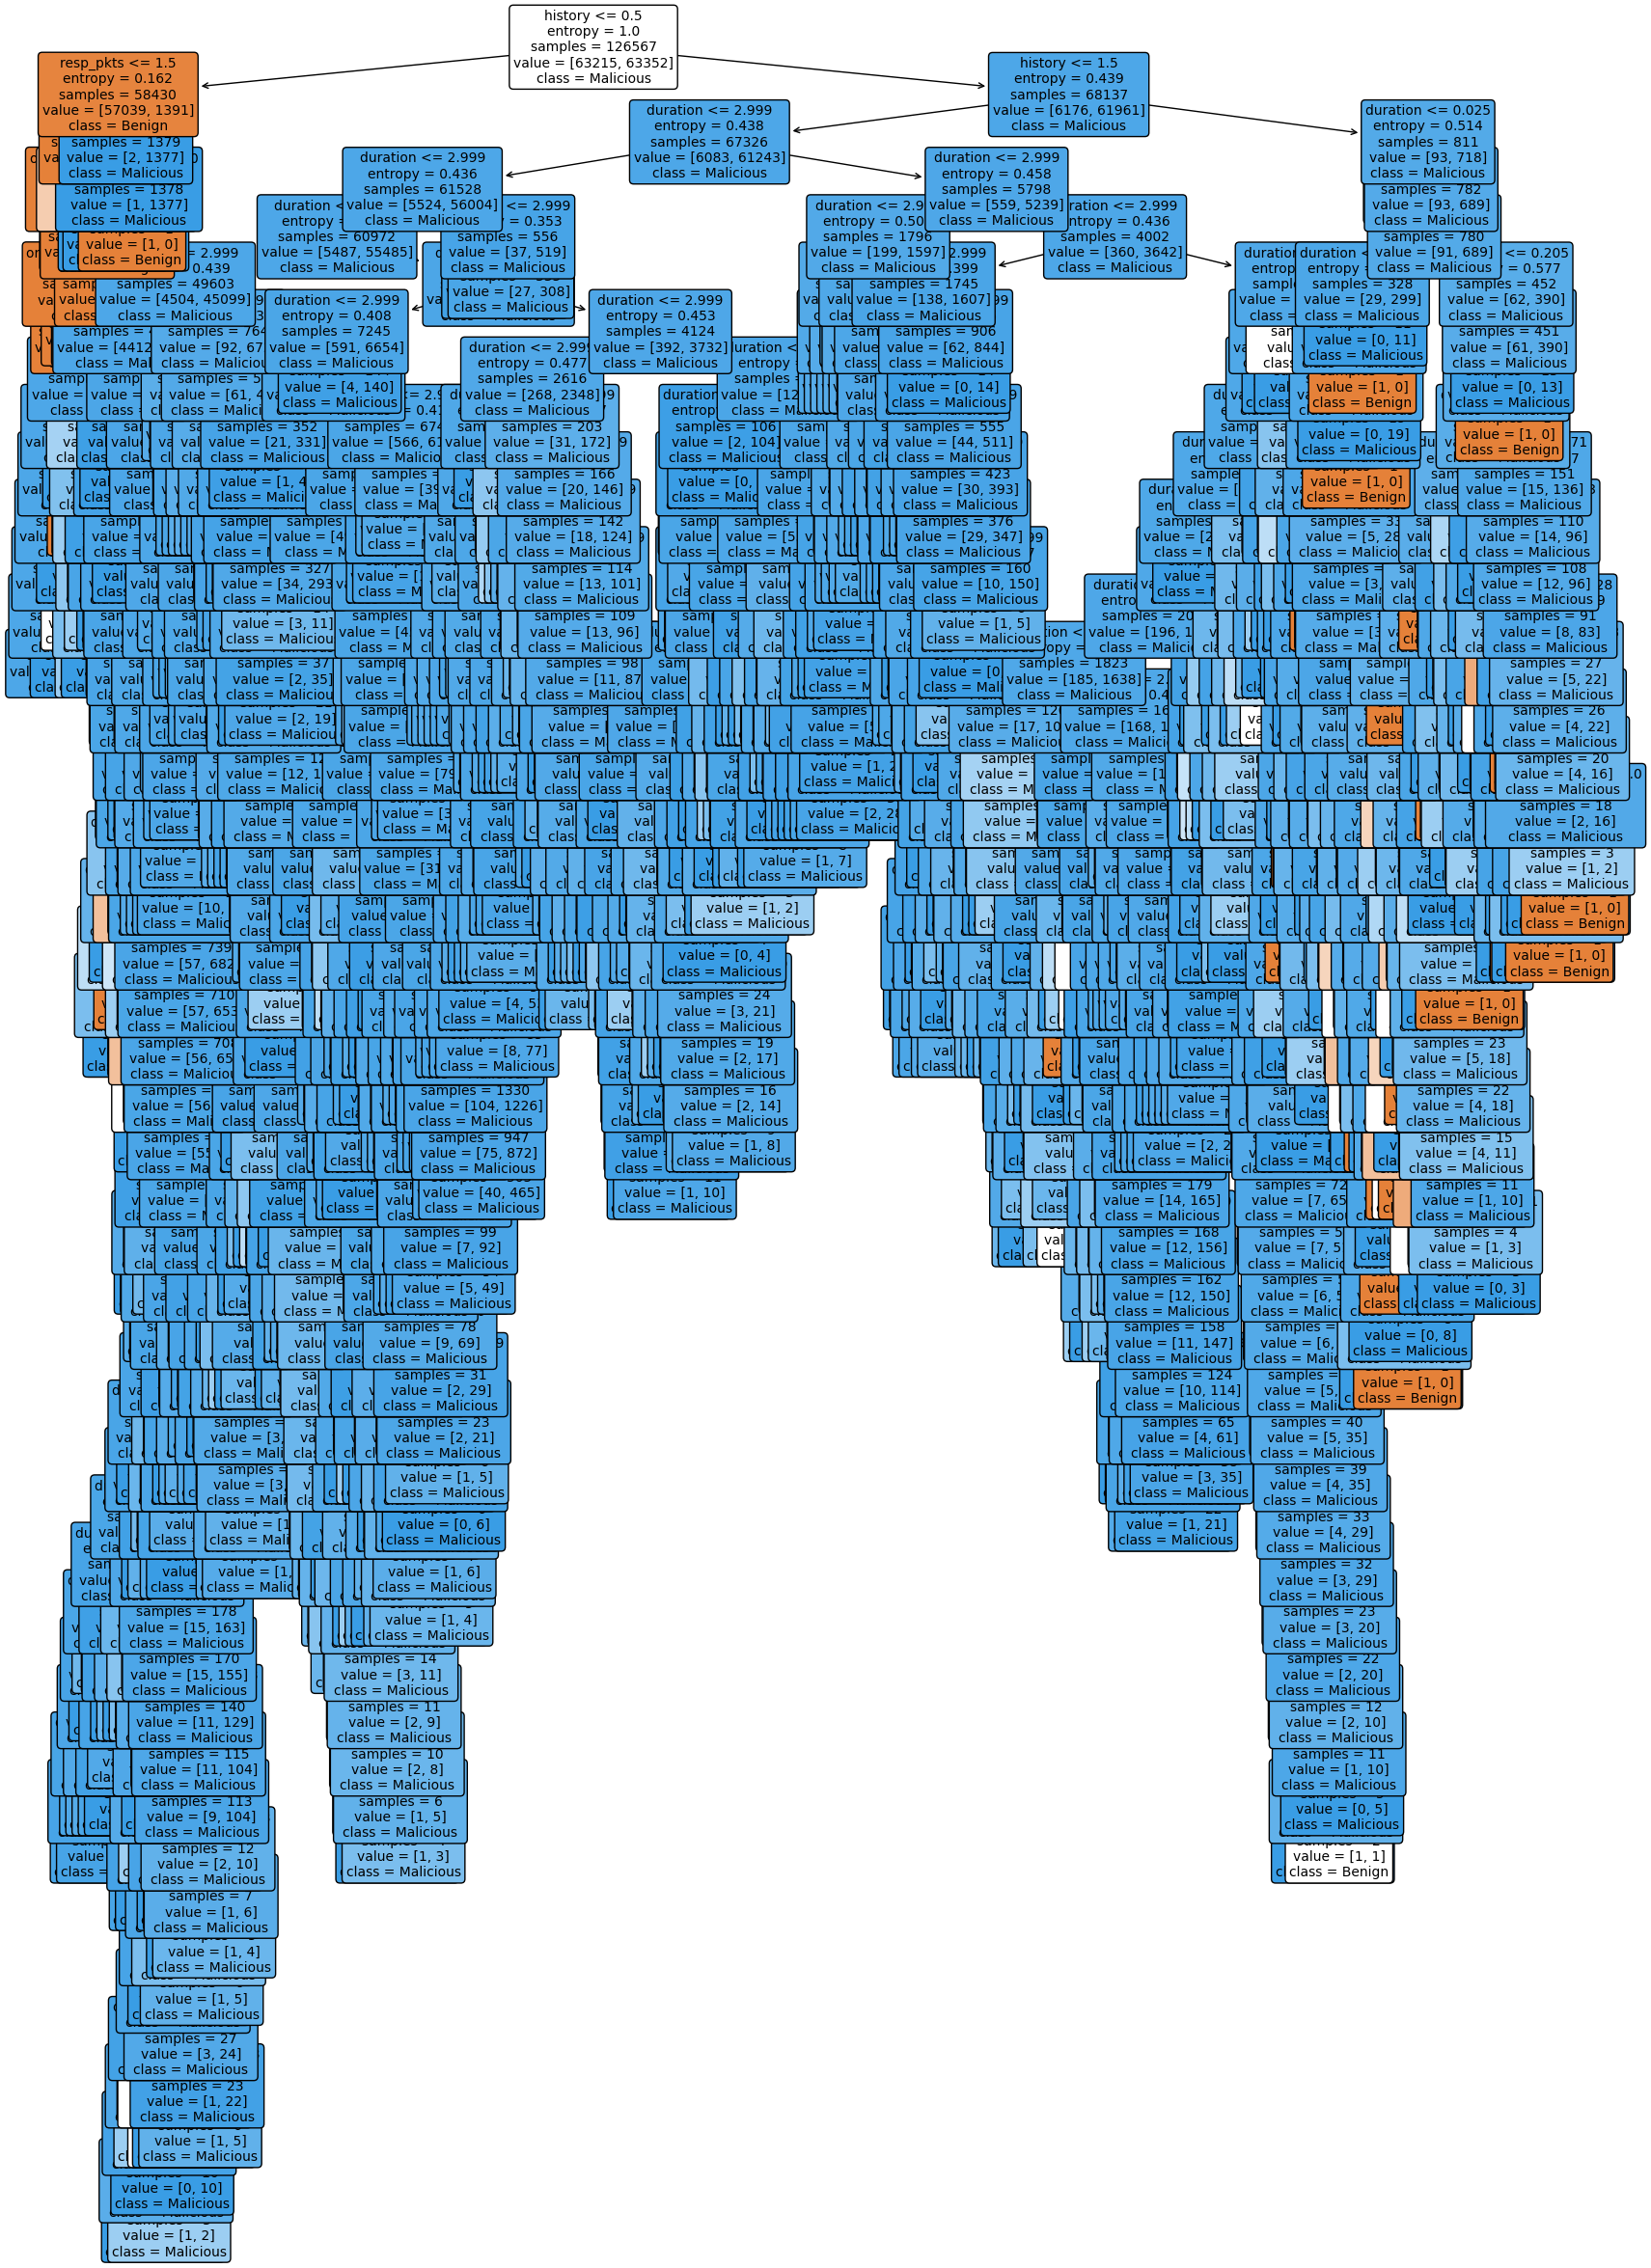

The decision tree has 1535 nodes.


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


# Initialize the Decision Tree Classifier with entropy criterion
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20,30))
tree_plot = plot_tree(clf, filled=True, rounded=True, feature_names=features.columns, class_names=['Benign', 'Malicious'],fontsize=10)
plt.show()

# Count the number of nodes in the tree
num_nodes = clf.tree_.node_count
print(f"The decision tree has {num_nodes} nodes.")


Confusion Matrix:
[[24541  2649]
 [   90 26963]]
Accuracy Score: 0.9495050052541342


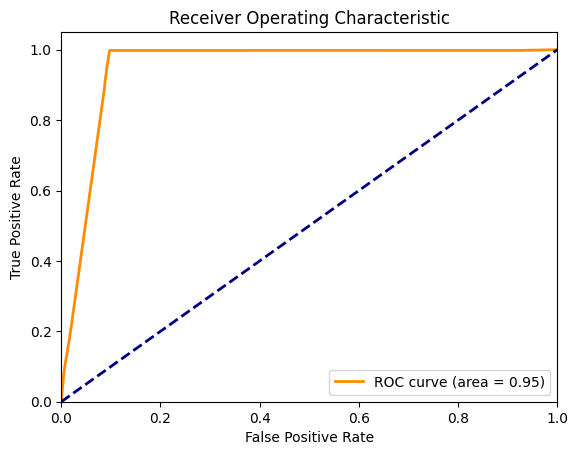

In [73]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predicting the Test set results
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [74]:
from sklearn.tree import export_text

decision_tree_rules = export_text(clf, feature_names=list(features.columns))

print(decision_tree_rules)

|--- history <= 0.50
|   |--- resp_pkts <= 1.50
|   |   |--- duration <= 68.03
|   |   |   |--- orig_ip_bytes <= 20.00
|   |   |   |   |--- class: 1
|   |   |   |--- orig_ip_bytes >  20.00
|   |   |   |   |--- duration <= 0.04
|   |   |   |   |   |--- orig_ip_bytes <= 48.00
|   |   |   |   |   |   |--- conn_state <= 4.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- conn_state >  4.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- orig_ip_bytes >  48.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- duration >  0.04
|   |   |   |   |   |--- proto <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- proto >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |--- duration >  68.03
|   |   |   |--- resp_ip_bytes <= 42.00
|   |   |   |   |--- class: 0
|   |   |   |--- resp_ip_bytes >  42.00
|   |   |   |   |--- class: 1
|   |--- resp_pkts >  1.50
|   |   |--- duration <= 0.04
|   |   |   |--- class: 0
|   |   |--- 

In [75]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Assuming X_train and y_train are your training data and labels
mi_scores = mutual_info_classif(X_train, y_train)

# Creating a Series for better visibility and sorting
mi_scores_series = pd.Series(mi_scores, index=X_train.columns)

# Sorting the series to get the features with the highest mutual information
mi_scores_series_sorted = mi_scores_series.sort_values(ascending=False)

print("Mutual information scores:\n", mi_scores_series_sorted)

# Selecting the top 2 features based on mutual information
top_2_features = mi_scores_series_sorted[:2].index.tolist()
print("Top 2 features based on mutual information:", top_2_features)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mutual information scores:
 proto            0.537260
orig_ip_bytes    0.534334
history          0.487345
duration         0.099971
orig_pkts        0.092546
conn_state       0.035137
resp_bytes       0.015878
resp_ip_bytes    0.015641
orig_bytes       0.015509
resp_pkts        0.007455
service          0.000000
dtype: float64
Top 2 features based on mutual information: ['proto', 'orig_ip_bytes']


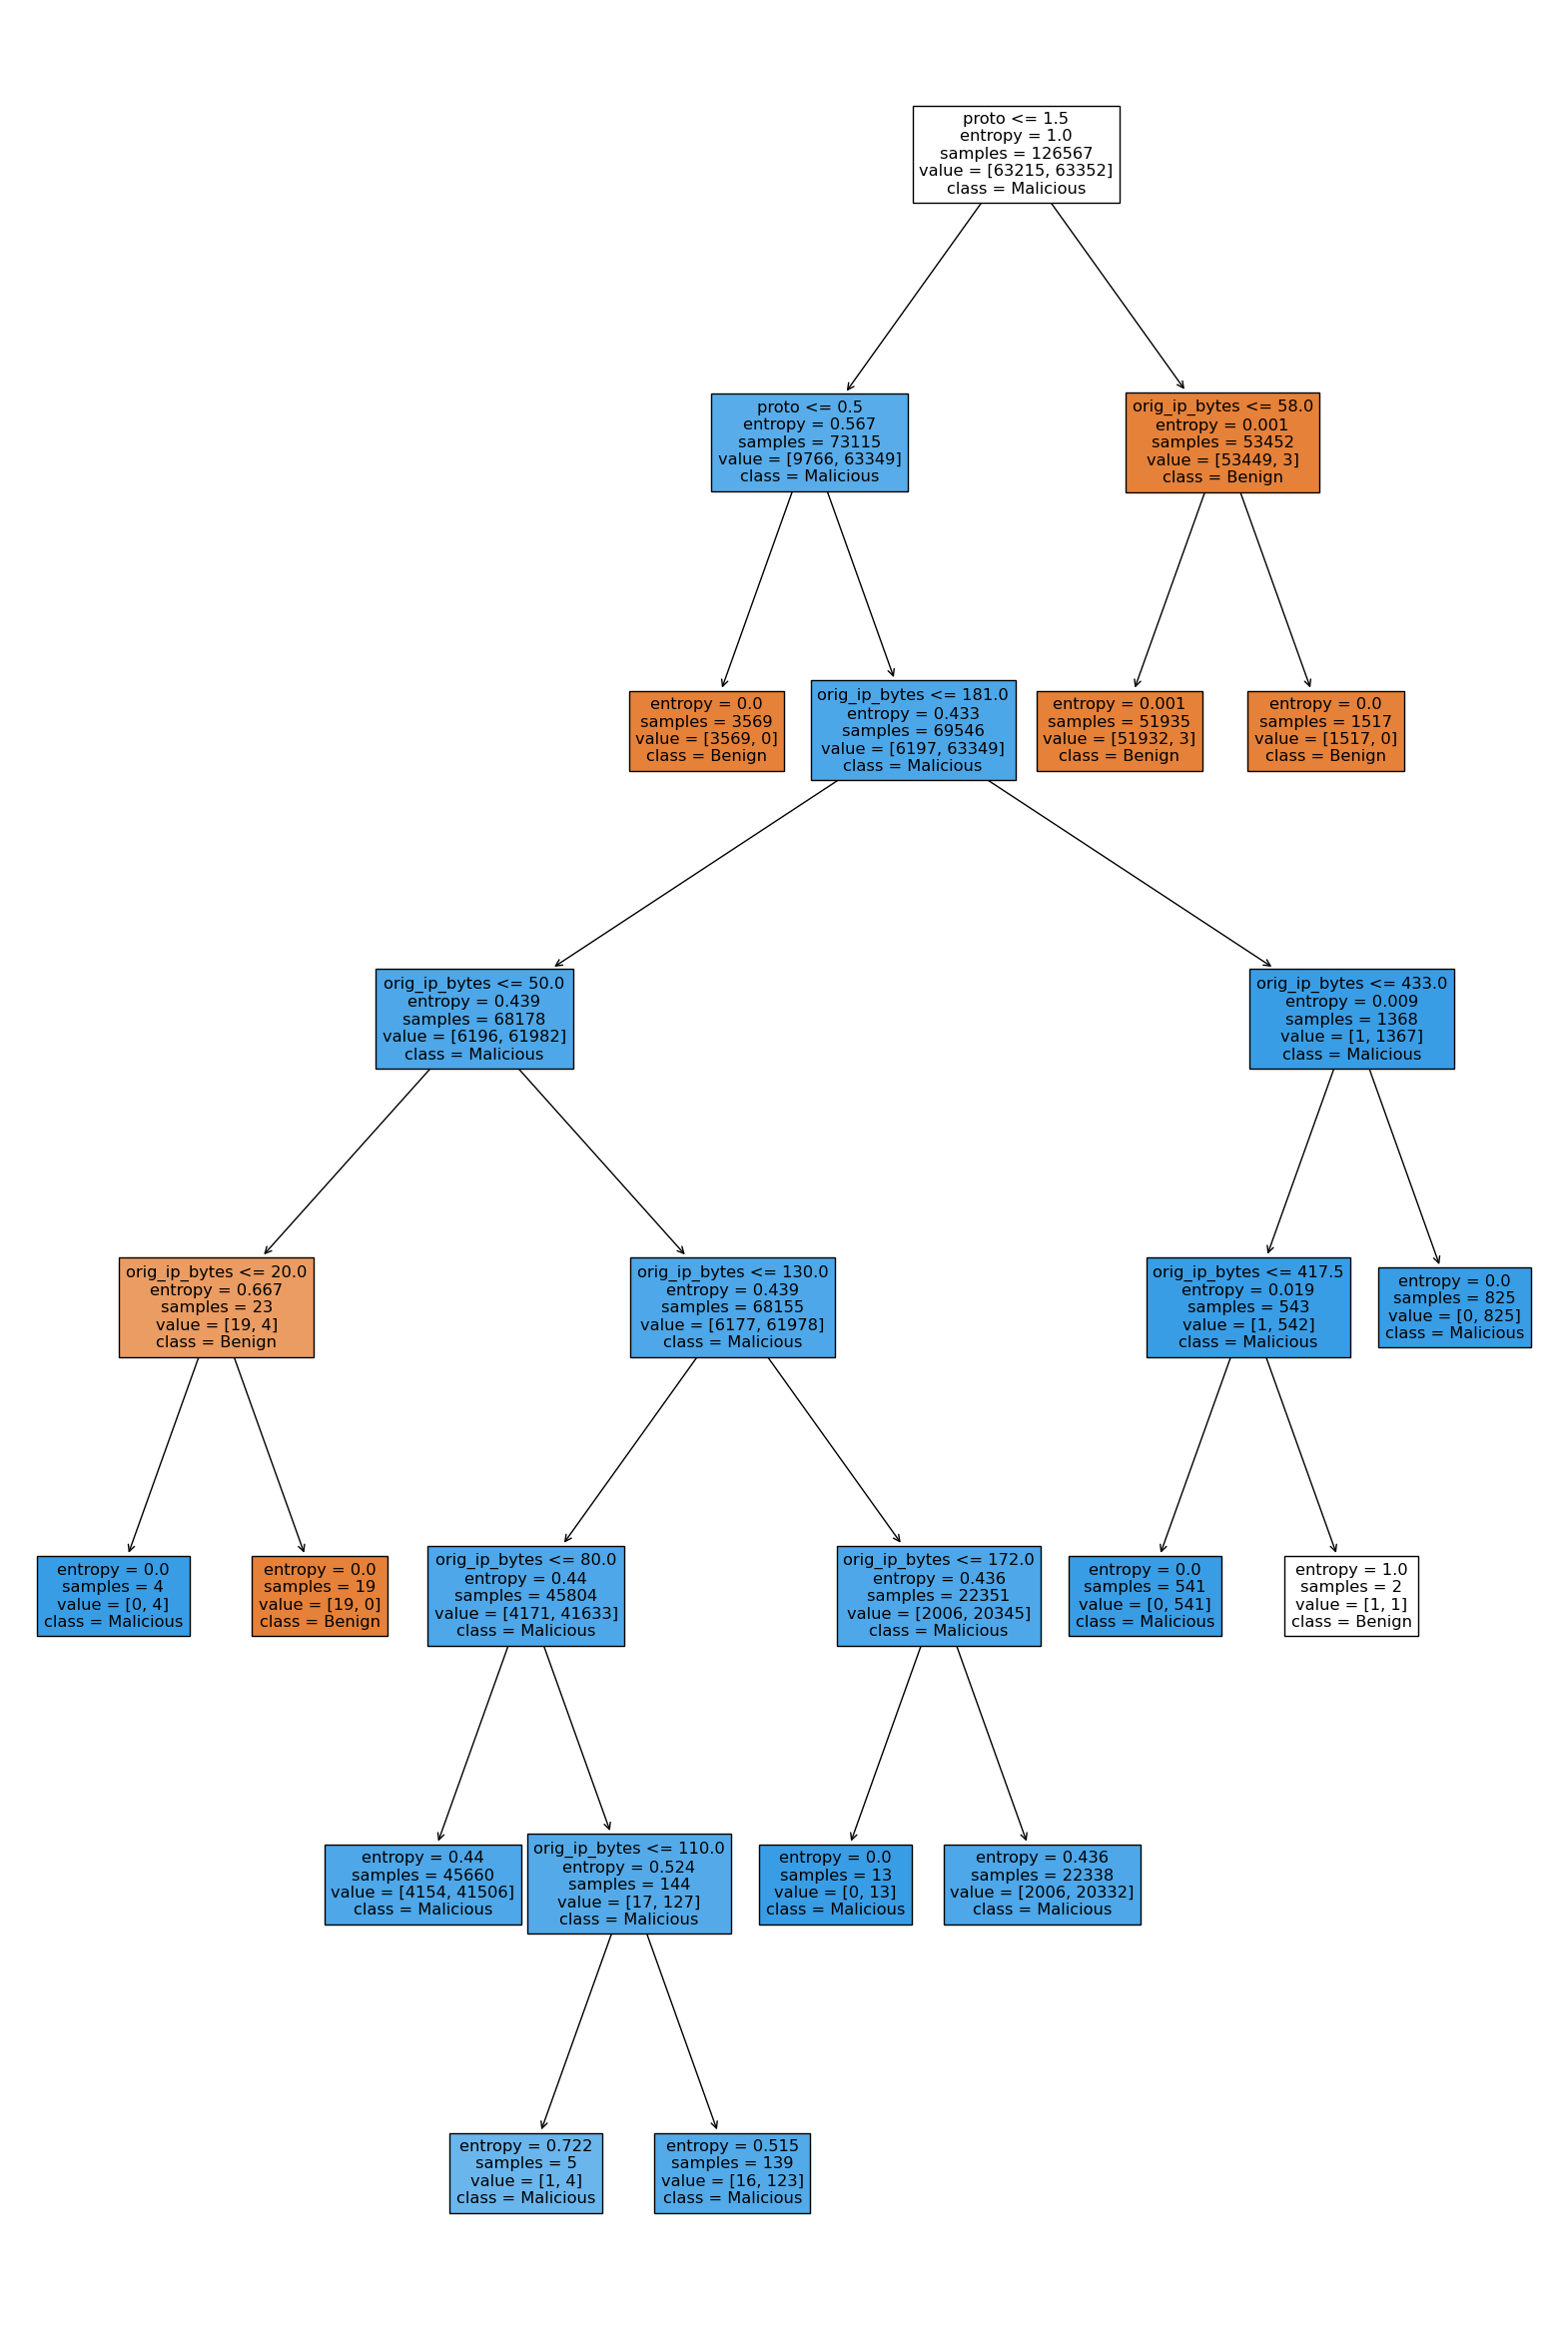

The decision tree with the top 2 features has 25 nodes.


In [76]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Assuming 'top_2_features' contains the names of the top two features
X_train_top2 = X_train[top_2_features]
X_test_top2 = X_test[top_2_features]

# Initialize the Decision Tree Classifier with entropy criterion
clf_top2 = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the classifier to the training data using only the top 2 features
clf_top2.fit(X_train_top2, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 30))
plot_tree(clf_top2, filled=True, feature_names=top_2_features, class_names=['Benign', 'Malicious'])
plt.show()

# Count the number of nodes in the tree
num_nodes_top2 = clf_top2.tree_.node_count
print(f"The decision tree with the top 2 features has {num_nodes_top2} nodes.")


Confusion Matrix:
[[24527  2663]
 [    4 27049]]
Accuracy Score: 0.9508323654665118


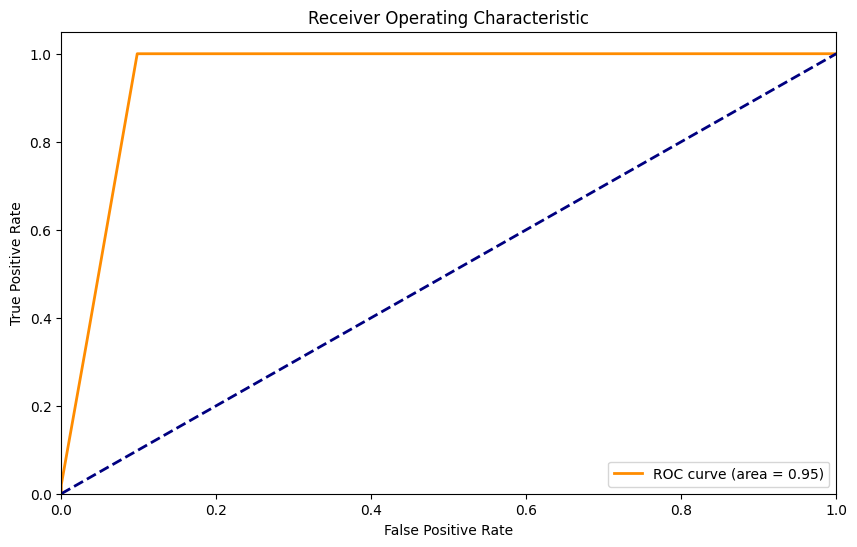

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Predicting the test set results
y_pred_top2 = clf_top2.predict(X_test_top2)
y_prob_top2 = clf_top2.predict_proba(X_test_top2)[:, 1]

# Confusion Matrix
cm_top2 = confusion_matrix(y_test, y_pred_top2)
print("Confusion Matrix:")
print(cm_top2)

# Accuracy Score
accuracy_top2 = accuracy_score(y_test, y_pred_top2)
print("Accuracy Score:", accuracy_top2)

# ROC Curve and AUC
fpr_top2, tpr_top2, thresholds_top2 = roc_curve(y_test, y_prob_top2)
roc_auc_top2 = auc(fpr_top2, tpr_top2)

plt.figure(figsize=(10, 6))
plt.plot(fpr_top2, tpr_top2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_top2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [78]:
from sklearn.tree import export_text

# Assuming clf_top2 is your Decision Tree classifier trained on the top 2 features
rules = export_text(clf_top2, feature_names=top_2_features)

print(rules)

|--- proto <= 1.50
|   |--- proto <= 0.50
|   |   |--- class: 0
|   |--- proto >  0.50
|   |   |--- orig_ip_bytes <= 181.00
|   |   |   |--- orig_ip_bytes <= 50.00
|   |   |   |   |--- orig_ip_bytes <= 20.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- orig_ip_bytes >  20.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- orig_ip_bytes >  50.00
|   |   |   |   |--- orig_ip_bytes <= 130.00
|   |   |   |   |   |--- orig_ip_bytes <= 80.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- orig_ip_bytes >  80.00
|   |   |   |   |   |   |--- orig_ip_bytes <= 110.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- orig_ip_bytes >  110.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- orig_ip_bytes >  130.00
|   |   |   |   |   |--- orig_ip_bytes <= 172.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- orig_ip_bytes >  172.00
|   |   |   |   |   |   |--- class: 1
|   |   |--- orig_ip_bytes >  181.00
|   |   |   |--

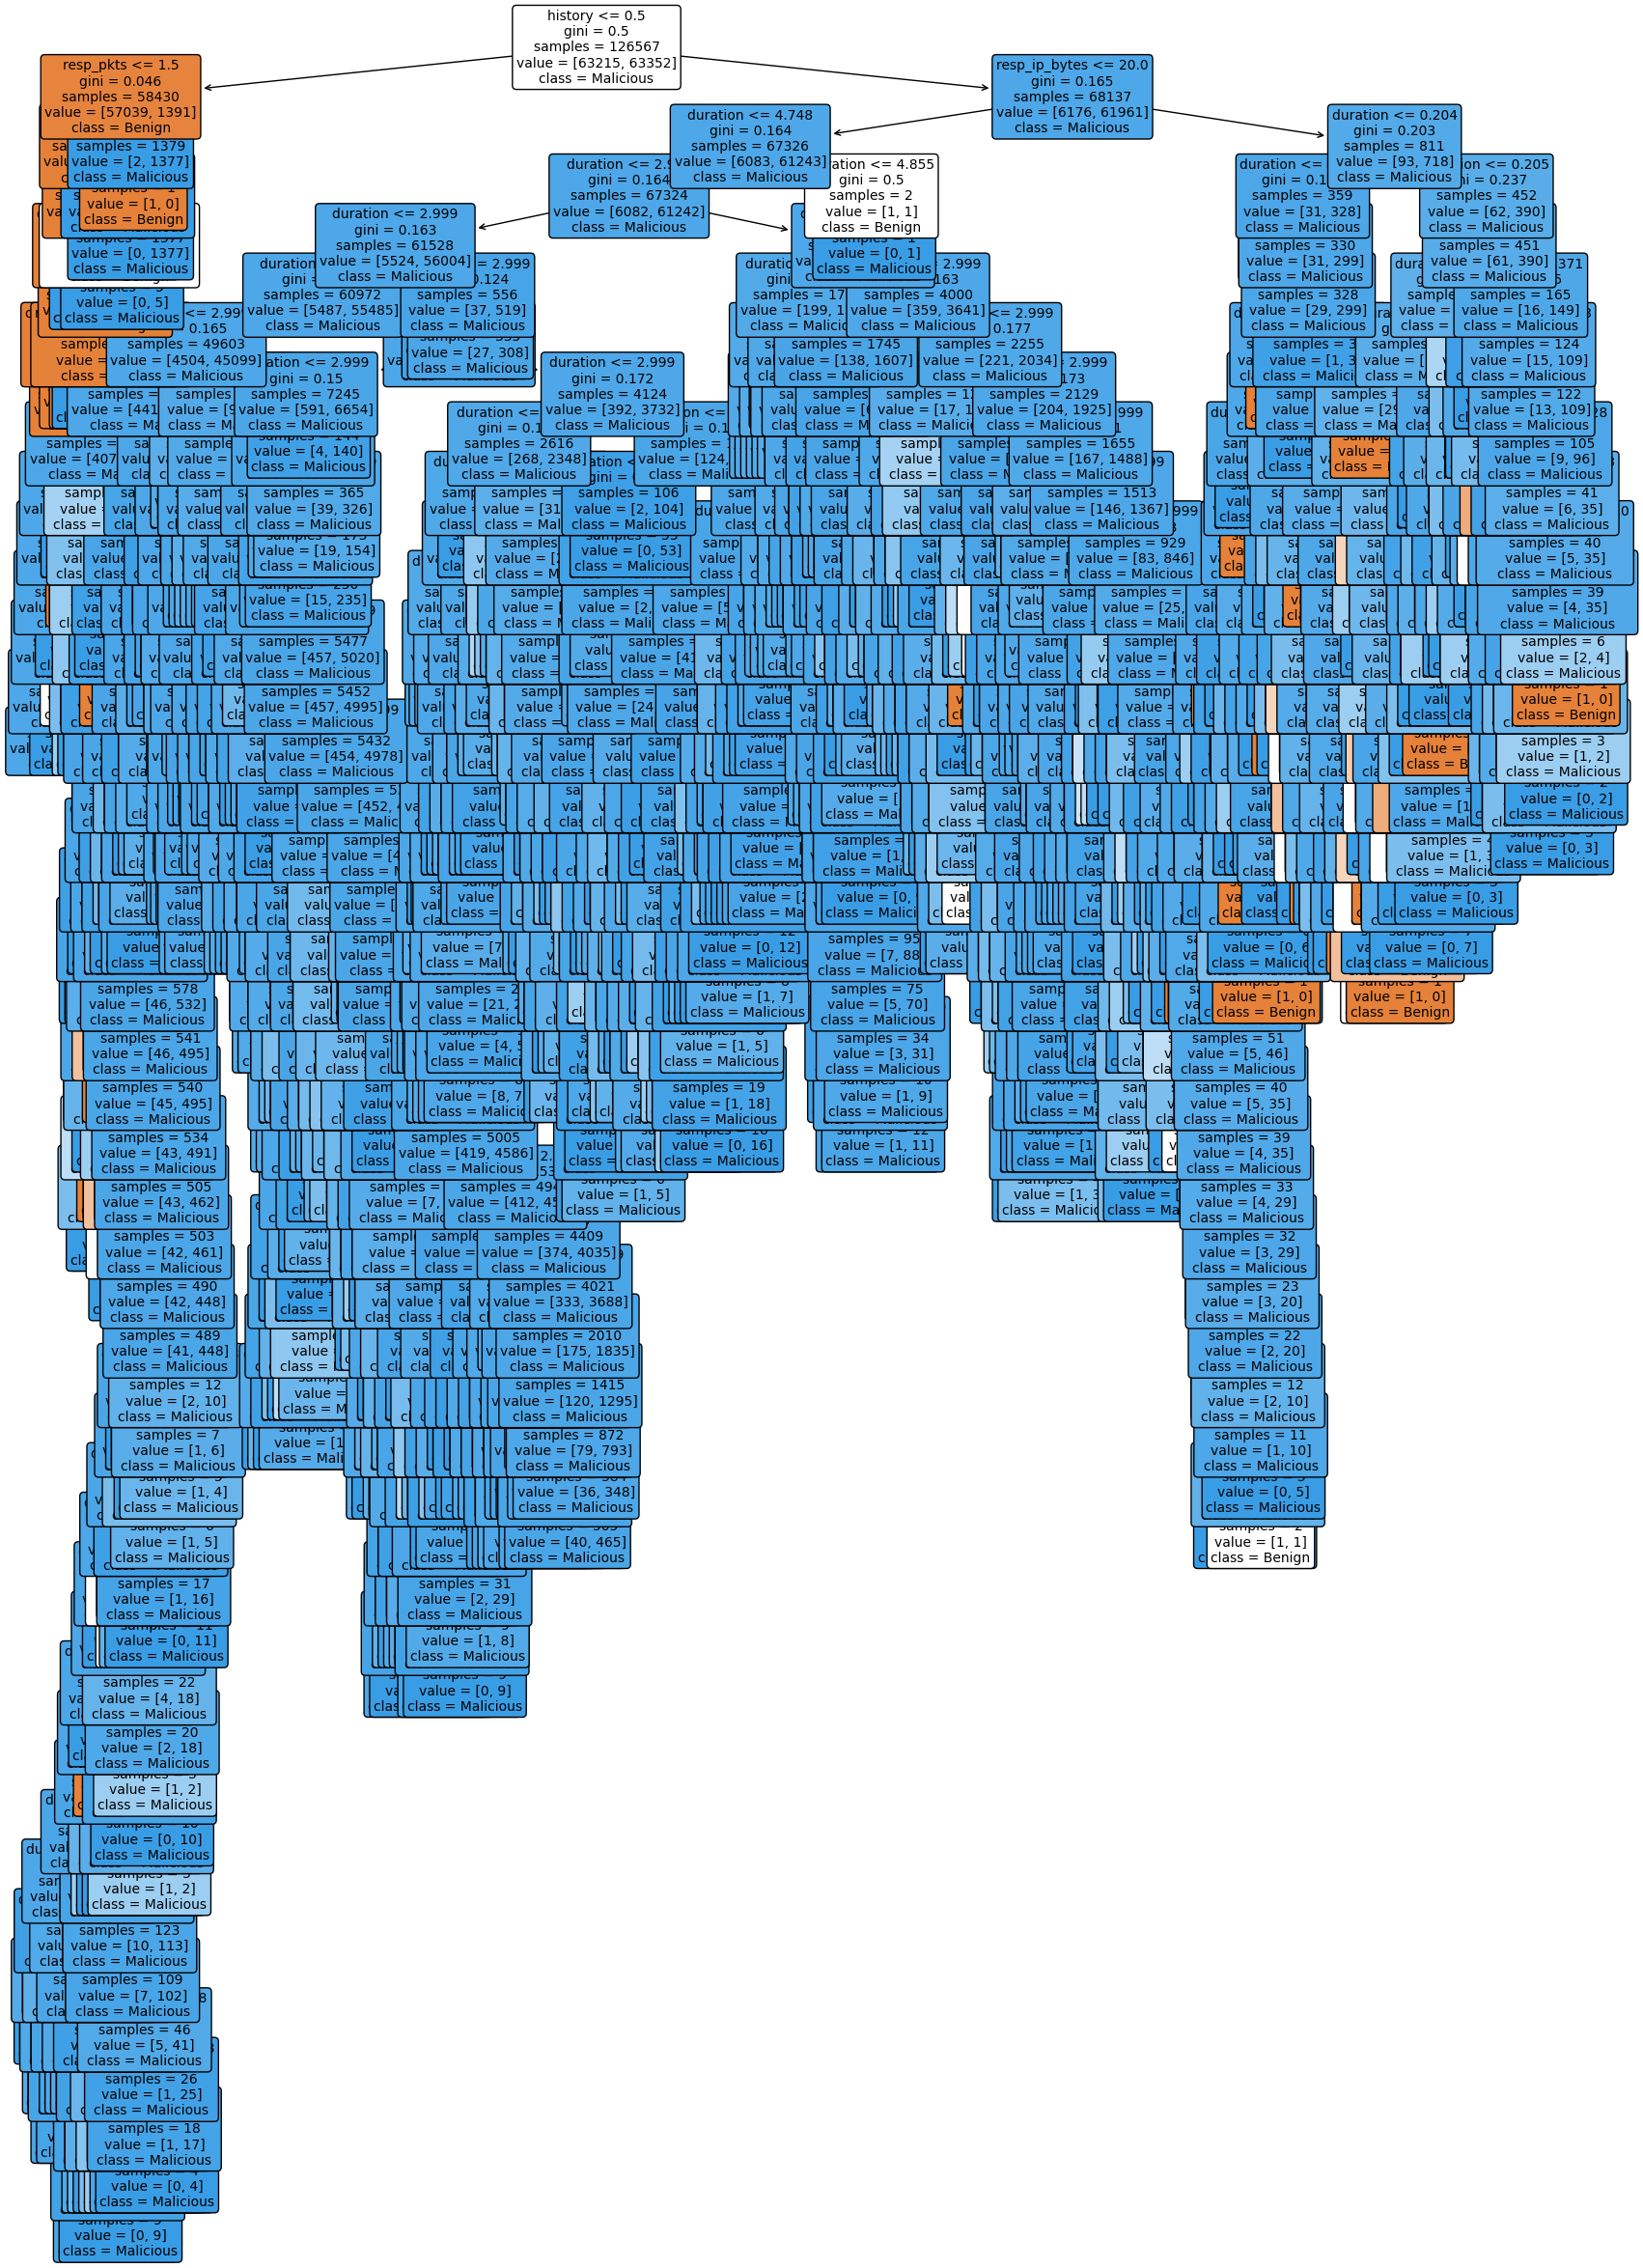

The decision tree has 1539 nodes.


In [79]:
# Initialize the Decision Tree Classifier with gini criterion
clf = DecisionTreeClassifier(criterion='gini', random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20,30))
tree_plot = plot_tree(clf, filled=True, rounded=True, feature_names=features.columns, class_names=['Benign', 'Malicious'],fontsize=10)
plt.show()

# Count the number of nodes in the tree
num_nodes = clf.tree_.node_count
print(f"The decision tree has {num_nodes} nodes.")

Confusion Matrix:
[[24540  2650]
 [   90 26963]]
Accuracy Score: 0.949486569695629


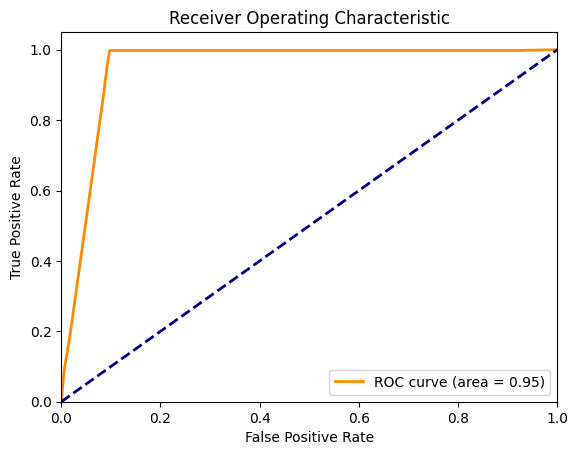

In [80]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [81]:
decision_tree_rules = export_text(clf, feature_names=list(features.columns))

print(decision_tree_rules)

|--- history <= 0.50
|   |--- resp_pkts <= 1.50
|   |   |--- orig_pkts <= 0.50
|   |   |   |--- class: 1
|   |   |--- orig_pkts >  0.50
|   |   |   |--- orig_pkts <= 8.50
|   |   |   |   |--- duration <= 149.15
|   |   |   |   |   |--- duration <= 0.04
|   |   |   |   |   |   |--- orig_ip_bytes <= 48.00
|   |   |   |   |   |   |   |--- conn_state <= 4.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- conn_state >  4.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- orig_ip_bytes >  48.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- duration >  0.04
|   |   |   |   |   |   |--- resp_ip_bytes <= 20.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- resp_ip_bytes >  20.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- duration >  149.15
|   |   |   |   |   |--- class: 1
|   |   |   |--- orig_pkts >  8.50
|   |   |   |   |--- resp_ip_bytes <= 42.00
|   |   |   |   |   |-

In [82]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Assuming X_train and y_train are your training data and labels
mi_scores = mutual_info_classif(X_train, y_train)

# Creating a Series for better visibility and sorting
mi_scores_series = pd.Series(mi_scores, index=X_train.columns)

# Sorting the series to get the features with the highest mutual information
mi_scores_series_sorted = mi_scores_series.sort_values(ascending=False)

print("Mutual information scores:\n", mi_scores_series_sorted)

# Selecting the top 2 features based on mutual information
top_2_features = mi_scores_series_sorted[:2].index.tolist()
print("Top 2 features based on mutual information:", top_2_features)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mutual information scores:
 proto            0.536289
orig_ip_bytes    0.532656
history          0.485873
duration         0.097993
orig_pkts        0.092604
conn_state       0.037473
resp_ip_bytes    0.019380
resp_bytes       0.016670
orig_bytes       0.016070
resp_pkts        0.010226
service          0.000000
dtype: float64
Top 2 features based on mutual information: ['proto', 'orig_ip_bytes']


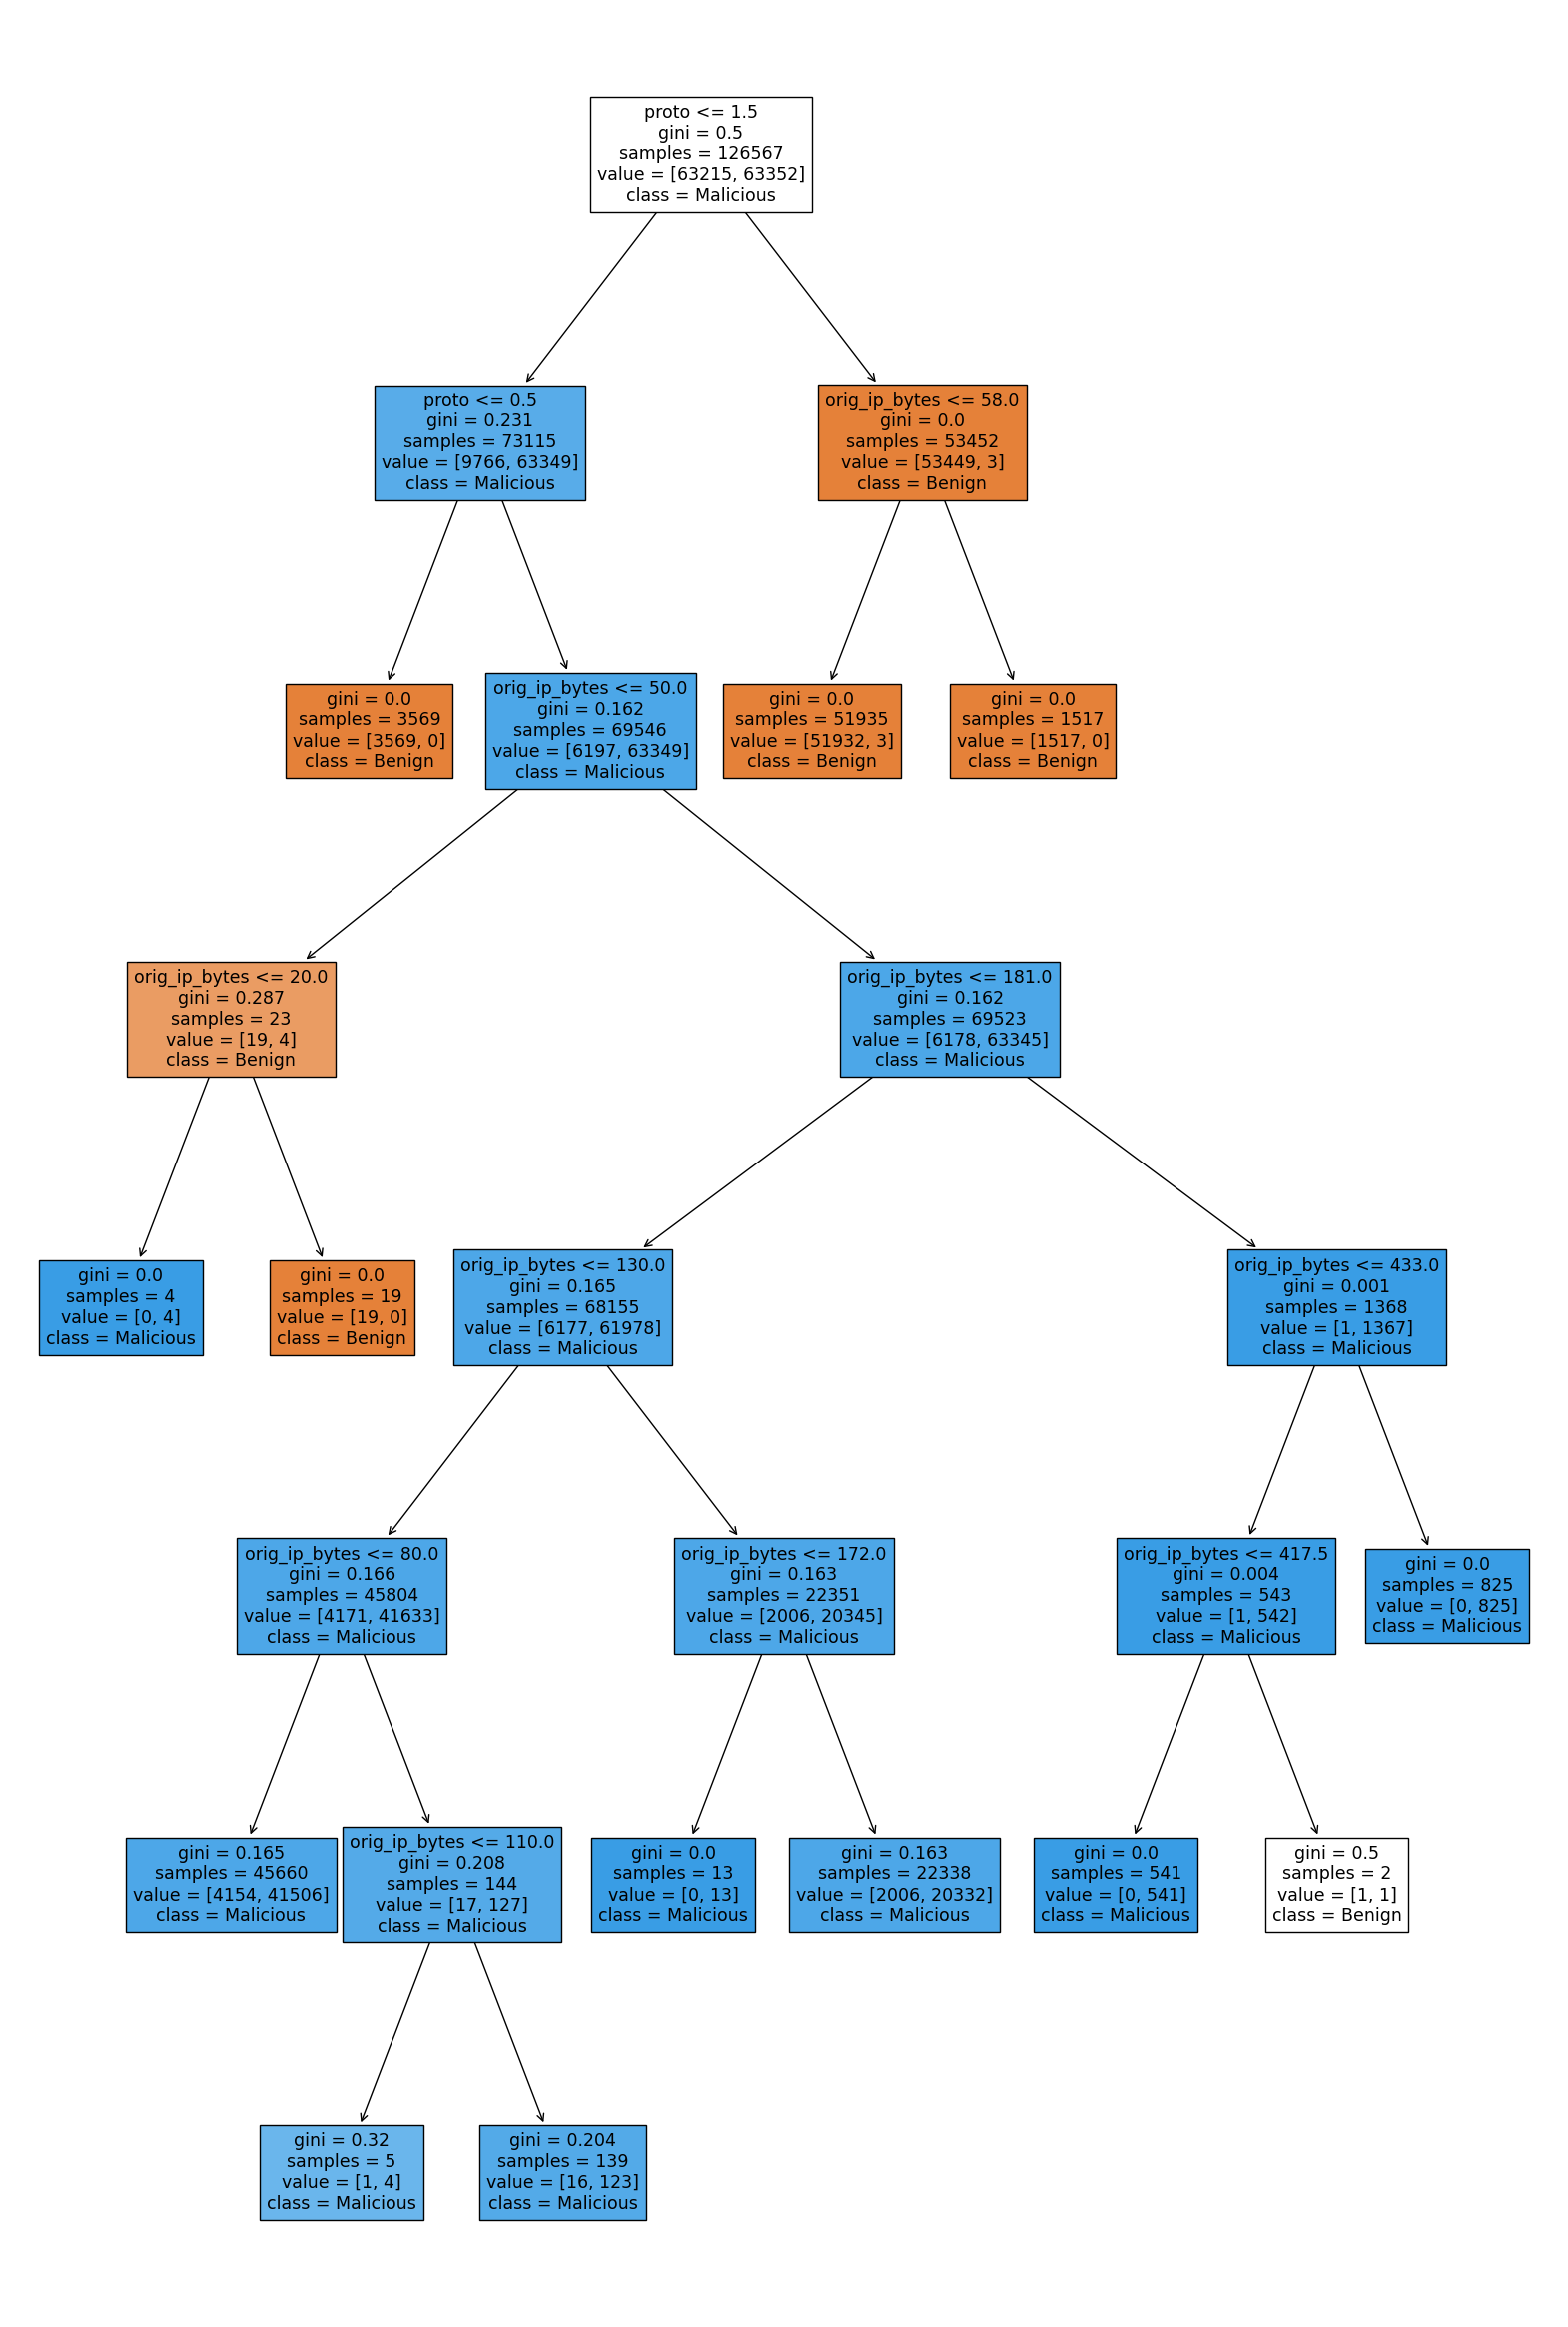

The decision tree with the top 2 features has 25 nodes.


In [83]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Assuming 'top_2_features' contains the names of the top two features
X_train_top2 = X_train[top_2_features]
X_test_top2 = X_test[top_2_features]

# Initialize the Decision Tree Classifier with entropy criterion
clf_top2 = DecisionTreeClassifier(criterion='gini', random_state=42)

# Fit the classifier to the training data using only the top 2 features
clf_top2.fit(X_train_top2, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 30))
plot_tree(clf_top2, filled=True, feature_names=top_2_features, class_names=['Benign', 'Malicious'])
plt.show()

# Count the number of nodes in the tree
num_nodes_top2 = clf_top2.tree_.node_count
print(f"The decision tree with the top 2 features has {num_nodes_top2} nodes.")
